<a href="https://colab.research.google.com/github/NathanDietrich/Artificial-Intelligence-and-Machine-Learning-portfolio/blob/main/FixingDat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance textblob ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=06648f3d98c468b498e275ab7edfd4534820ddcd4f95c756e693c2e0c049481d
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
!nvidia-smi


Thu Feb 27 22:37:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install -U tensorflow tensorflow-gpu


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [4]:
import tensorflow as tf

# Enable GPU memory growth (prevents out-of-memory errors)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU Memory Growth Enabled")
    except RuntimeError as e:
        print(e)

# Check if mixed precision is available (T4 supports FP16 for speed boost)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

print("✅ Mixed Precision Enabled for Faster Training")


✅ GPU Memory Growth Enabled
✅ Mixed Precision Enabled for Faster Training


In [5]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
import os
import requests
import datetime
import pandas as pd
import time
from google.colab import userdata  # For fetching stored API keys
from textblob import TextBlob

def fetch_stock_data_polygon(ticker, start_date, end_date, api_key):
    """
    Fetches historical stock data from Polygon.io.
    """
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{end_date}?apiKey={api_key}"
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Error fetching stock data: {response.text}")
        return None

    data = response.json()
    if "results" not in data:
        print("No results found.")
        return None

    # Convert response to DataFrame
    df = pd.DataFrame(data["results"])
    df["Date"] = pd.to_datetime(df["t"], unit="ms").dt.date
    df.rename(columns={"o": "Open", "h": "High", "l": "Low", "c": "Close", "v": "Volume"}, inplace=True)
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]]

    return df

def fetch_sentiment_data_polygon(ticker, start_date, end_date, api_key, limit=1000):
    """
    Fetches sentiment data from Polygon.io in chunks and computes daily sentiment scores.
    """
    url = "https://api.polygon.io/v2/reference/news"
    all_results = []
    current_start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    final_end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")

    while current_start_date < final_end_date:
        chunk_end_date = current_start_date + datetime.timedelta(days=30)
        if chunk_end_date > final_end_date:
            chunk_end_date = final_end_date

        chunk_start_str = current_start_date.strftime("%Y-%m-%d")
        chunk_end_str = chunk_end_date.strftime("%Y-%m-%d")

        print(f"📡 Fetching sentiment data from {chunk_start_str} to {chunk_end_str}...")

        params = {
            "ticker": ticker,
            "published_utc.gte": chunk_start_str,
            "published_utc.lte": chunk_end_str,
            "apiKey": api_key,
            "limit": limit
        }

        while True:
            response = requests.get(url, params=params)
            if response.status_code == 200:
                data = response.json()
                results = data.get("results", [])
                all_results.extend(results)

                next_cursor = data.get("next_cursor")
                if not next_cursor:
                    break

                params["cursor"] = next_cursor
            else:
                print(f"⚠️ Error fetching sentiment data: {response.status_code}, {response.text}")
                break

        current_start_date = chunk_end_date
        time.sleep(14)  # Avoid hitting API rate limits

    return all_results

def analyze_sentiment(news_data):
    """
    Uses TextBlob to compute sentiment polarity and subjectivity for each news article.
    """
    analyzed_data = []
    for article in news_data:
        title = article.get("title", "")
        description = article.get("description", "")
        full_text = f"{title} {description}"
        sentiment = TextBlob(full_text).sentiment

        analyzed_data.append({
            "title": title,
            "description": description,
            "published_date": article.get("published_utc", ""),
            "sentiment_polarity": sentiment.polarity,
            "sentiment_subjectivity": sentiment.subjectivity
        })

    return analyzed_data

def merge_stock_and_sentiment(stock_df, sentiment_data):
    """
    Merges stock data with sentiment data by date.
    """
    sentiment_df = pd.DataFrame(sentiment_data)

    if sentiment_df.empty:
        print("⚠️ No sentiment data found, proceeding without sentiment.")
        stock_df["sentiment_polarity"] = 0  # Default neutral
        stock_df["sentiment_subjectivity"] = 0
        return stock_df

    sentiment_df['published_date'] = pd.to_datetime(sentiment_df['published_date'], errors='coerce')
    sentiment_df['Date'] = sentiment_df['published_date'].dt.date

    # Group sentiment data by date
    daily_sentiment = sentiment_df.groupby('Date').agg({
        'sentiment_polarity': 'mean',
        'sentiment_subjectivity': 'mean'
    }).reset_index()

    # Merge with stock data
    merged_df = pd.merge(stock_df, daily_sentiment, on="Date", how="left")

    # Handle missing sentiment values (forward fill) while ensuring numeric dtype
    merged_df[['sentiment_polarity', 'sentiment_subjectivity']] = (
        merged_df[['sentiment_polarity', 'sentiment_subjectivity']]
        .replace(0, pd.NA)  # Convert zeros to NaN
        .infer_objects(copy=False)  # Ensure numeric dtype
        .ffill()  # Forward fill missing values
    )
    # Fill any remaining NaN values
    merged_df.fillna(0, inplace=True)

    return merged_df

def main():
    """
    Main function to fetch stock data and sentiment data, merge them, and save to a raw CSV file.
    """
    # Get today's date
    today = datetime.date.today().strftime("%Y-%m-%d")

    # Set fixed start date
    start_date = "2021-01-01"
    end_date = today

    # Ask user for stock ticker
    ticker = input("Enter the stock ticker (e.g., TSLA): ").strip().upper()

    # Load Polygon API key
    api_key = userdata.get("Polygon_Key")
    if not api_key:
        print("❌ Error: Polygon API key not found.")
        return

    # Fetch stock data
    print(f"\n📊 Fetching stock data for {ticker} from {start_date} to {end_date}...")
    stock_df = fetch_stock_data_polygon(ticker, start_date, end_date, api_key)

    if stock_df is None:
        print("❌ No stock data found. Exiting.")
        return

    # Fetch sentiment data
    print(f"\n📰 Fetching sentiment data for {ticker} from {start_date} to {end_date}...")
    news_data = fetch_sentiment_data_polygon(ticker, start_date, end_date, api_key, limit=1000)

    if not news_data:
        print("⚠️ No news data found. Proceeding without sentiment data.")

    print("\n💡 Performing sentiment analysis...")
    sentiment_data = analyze_sentiment(news_data)

    # Merge stock and sentiment data
    print("\n🔗 Merging stock and sentiment data...")
    merged_df = merge_stock_and_sentiment(stock_df, sentiment_data)

    # Save raw data
    filename = f"{ticker}_{start_date}_to_{end_date}_raw.csv"
    merged_df.to_csv(filename, index=False)
    print(f"✅ Raw stock data with sentiment saved to: {filename}")

# Run the main function
if __name__ == "__main__":
    main()


Enter the stock ticker (e.g., TSLA): qqq

📊 Fetching stock data for QQQ from 2021-01-01 to 2025-02-27...

📰 Fetching sentiment data for QQQ from 2021-01-01 to 2025-02-27...
📡 Fetching sentiment data from 2021-01-01 to 2021-01-31...
📡 Fetching sentiment data from 2021-01-31 to 2021-03-02...
📡 Fetching sentiment data from 2021-03-02 to 2021-04-01...
📡 Fetching sentiment data from 2021-04-01 to 2021-05-01...
📡 Fetching sentiment data from 2021-05-01 to 2021-05-31...
📡 Fetching sentiment data from 2021-05-31 to 2021-06-30...
📡 Fetching sentiment data from 2021-06-30 to 2021-07-30...
📡 Fetching sentiment data from 2021-07-30 to 2021-08-29...
📡 Fetching sentiment data from 2021-08-29 to 2021-09-28...
📡 Fetching sentiment data from 2021-09-28 to 2021-10-28...
📡 Fetching sentiment data from 2021-10-28 to 2021-11-27...
📡 Fetching sentiment data from 2021-11-27 to 2021-12-27...
📡 Fetching sentiment data from 2021-12-27 to 2022-01-26...
📡 Fetching sentiment data from 2022-01-26 to 2022-02-25...
📡

<ipython-input-14-f6902d0fce2d>:131: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .ffill()  # Forward fill missing values


In [6]:
import os
import re
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from ta.momentum import RSIIndicator, WilliamsRIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands, AverageTrueRange

def get_valid_files():
    """Detects and lists valid raw stock data files in Colab's working directory."""
    uploaded_files = os.listdir()
    pattern = re.compile(r"^([A-Za-z]+)_\d{4}-\d{2}-\d{2}_to_\d{4}-\d{2}-\d{2}_raw\.csv$", re.IGNORECASE)
    valid_files = {f: pattern.match(f).group(1).upper() for f in uploaded_files if pattern.match(f)}
    return valid_files

def select_file():
    """Selects the most recent stock data file or prompts the user to choose if multiple are found."""
    valid_files = get_valid_files()

    if not valid_files:
        print("❌ No valid raw stock data files found. Please upload one.")
        return None, None

    if len(valid_files) == 1:
        filename = list(valid_files.keys())[0]
        stock_ticker = valid_files[filename]
        print(f"✅ Automatically selected: {filename} ({stock_ticker})")
        return filename, stock_ticker

    print("🔍 Multiple stock raw files detected. Please choose one:")
    for i, fname in enumerate(valid_files.keys()):
        print(f"{i + 1}. {fname} ({valid_files[fname]})")

    choice = int(input("Enter the number of the file to use: ")) - 1
    filename = list(valid_files.keys())[choice]
    stock_ticker = valid_files[filename]

    print(f"✅ Selected: {filename} ({stock_ticker})")
    return filename, stock_ticker

def preprocess_stock_data(file_name):
    """
    Processes raw stock data:
    - Saves preprocessed (unscaled) dataset
    - Scales stock-related features separately from sentiment
    - Saves fully scaled dataset for model training
    - Splits into train (64%), validation (16%), and test (20%) sets
    """
    # Load raw data
    df = pd.read_csv(file_name)

    # Convert Date to datetime and sort
    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values("Date", inplace=True)

    # === Add Technical Indicators ===
    df["RSI"] = RSIIndicator(close=df["Close"]).rsi()
    df["MACD"] = MACD(close=df["Close"]).macd()
    df["ATR"] = AverageTrueRange(high=df["High"], low=df["Low"], close=df["Close"]).average_true_range()

    # Bollinger Bands
    bb = BollingerBands(close=df["Close"])
    df["BB_High"] = bb.bollinger_hband()
    df["BB_Low"] = bb.bollinger_lband()

    # Williams %R
    df["Williams_%R"] = WilliamsRIndicator(high=df["High"], low=df["Low"], close=df["Close"]).williams_r()

    # === Handle Missing Values AFTER Adding Indicators ===
    df.ffill(inplace=True)  # Forward fill missing values
    df.dropna(inplace=True)  # Drop any remaining NaNs

    # === Save Preprocessed Data (Unscaled) ===
    preprocessed_filename = file_name.replace("_raw.csv", "_preprocessed.csv")
    df.to_csv(preprocessed_filename, index=False)
    print(f"✅ Saved unscaled preprocessed data: {preprocessed_filename}")

    # === Scaling ===
    sentiment_features = ["sentiment_polarity", "sentiment_subjectivity"]
    stock_features = ["Open", "High", "Low", "Volume", "ATR", "BB_High", "BB_Low", "Williams_%R"]

    # Scale stock-related features only
    scaler_x = MinMaxScaler()
    X_stock_scaled = scaler_x.fit_transform(df[stock_features])

    # Keep sentiment values unchanged and concatenate them with the scaled stock features
    X_final = np.hstack((X_stock_scaled, df[sentiment_features].values))  # No scaling on sentiment

    # Scale target (Close price)
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(df[["Close"]])

    # === Save Fully Scaled Dataset ===
    scaled_df = pd.DataFrame(X_final, columns=stock_features + sentiment_features)
    scaled_df["Close"] = y_scaled  # Add scaled target back
    scaled_df.insert(0, "Date", df["Date"].values)  # Reinsert date

    scaled_filename = file_name.replace("_raw.csv", "_scaled.csv")
    scaled_df.to_csv(scaled_filename, index=False)
    print(f"✅ Saved fully scaled data: {scaled_filename}")

    # === Convert to sequences for LSTM/CNN ===
    sequence_length = 30
    X_seq, y_seq = [], []
    for i in range(len(X_final) - sequence_length):
        X_seq.append(X_final[i : i + sequence_length])
        y_seq.append(y_scaled[i + sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # === Train (64%), Validation (16%), and Test (20%) Split ===
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Save scalers with simple names
    joblib.dump(scaler_x, "scaler_x.pkl")
    joblib.dump(scaler_y, "scaler_y.pkl")

    # === Save Train, Validation, and Test Sets with Simple Names ===
    np.save("X_train.npy", X_train)
    np.save("X_val.npy", X_val)
    np.save("X_test.npy", X_test)
    np.save("y_train.npy", y_train)
    np.save("y_val.npy", y_val)
    np.save("y_test.npy", y_test)

    print(f"✅ Preprocessing complete for {file_name}. Files saved:")
    print(f"- X_train.npy, X_val.npy, X_test.npy")
    print(f"- y_train.npy, y_val.npy, y_test.npy")
    print(f"- scaler_x.pkl, scaler_y.pkl")
    print(f"- {preprocessed_filename} (Unscaled dataset)")
    print(f"- {scaled_filename} (Fully scaled dataset)")

    return "scaler_x.pkl", "scaler_y.pkl"

def inverse_transform_predictions(scaler_filename, scaled_data):
    """Reverts the scaled predictions back to original values."""
    scaler = joblib.load(scaler_filename)
    return scaler.inverse_transform(scaled_data)

def main():
    """
    Main function to:
    - Detect and select the correct raw data file.
    - Preprocess stock data (save both unscaled & scaled versions).
    - Save transformed data and scalers.
    """
    file_name, ticker = select_file()

    if file_name:
        preprocess_stock_data(file_name)
    else:
        print("❌ No valid file selected. Exiting.")

# Run main function
if __name__ == "__main__":
    main()


✅ Automatically selected: QQQ_2021-01-01_to_2025-02-27_raw.csv (QQQ)
✅ Saved unscaled preprocessed data: QQQ_2021-01-01_to_2025-02-27_preprocessed.csv
✅ Saved fully scaled data: QQQ_2021-01-01_to_2025-02-27_scaled.csv
✅ Preprocessing complete for QQQ_2021-01-01_to_2025-02-27_raw.csv. Files saved:
- X_train.npy, X_val.npy, X_test.npy
- y_train.npy, y_val.npy, y_test.npy
- scaler_x.pkl, scaler_y.pkl
- QQQ_2021-01-01_to_2025-02-27_preprocessed.csv (Unscaled dataset)
- QQQ_2021-01-01_to_2025-02-27_scaled.csv (Fully scaled dataset)


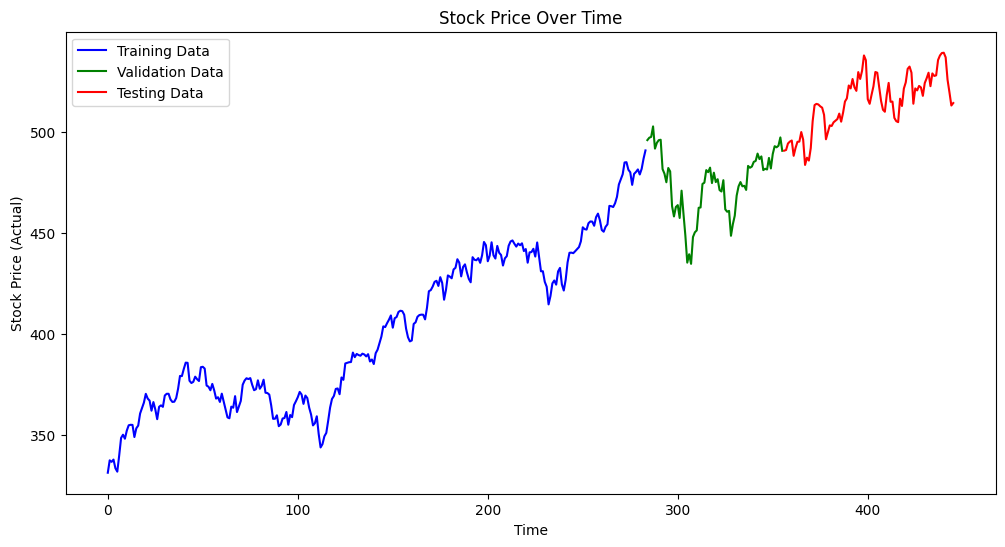

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

# Load preprocessed data from files
X_train = np.load("X_train.npy")
X_val = np.load("X_val.npy")  # Load validation set
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_val = np.load("y_val.npy")  # Load validation set
y_test = np.load("y_test.npy")

# Load scaler for target variable (stock prices)
scaler_y = joblib.load("scaler_y.pkl")

# Unscale target values
y_train_unscaled = scaler_y.inverse_transform(y_train)
y_val_unscaled = scaler_y.inverse_transform(y_val)
y_test_unscaled = scaler_y.inverse_transform(y_test)

# Plot actual stock price over time
plt.figure(figsize=(12,6))
plt.plot(y_train_unscaled, label="Training Data", color="blue")
plt.plot(range(len(y_train_unscaled), len(y_train_unscaled) + len(y_val_unscaled)),
         y_val_unscaled, label="Validation Data", color="green")
plt.plot(range(len(y_train_unscaled) + len(y_val_unscaled),
               len(y_train_unscaled) + len(y_val_unscaled) + len(y_test_unscaled)),
         y_test_unscaled, label="Testing Data", color="red")

plt.xlabel("Time")
plt.ylabel("Stock Price (Actual)")
plt.title("Stock Price Over Time")
plt.legend()
plt.show()


In [17]:
#Next step is to expand the data length and make a back test function that goes and makes new models periodically

In [11]:
!pip install -U keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.4 MB/s eta 0:00:00


Trial 15 Complete [00h 02m 38s]
val_loss: 0.0017570252142225702

Best val_loss So Far: 0.001496544573456049
Total elapsed time: 00h 40m 30s
✅ Best hyperparameters saved in EnsembleModel2!
Epoch 1/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - loss: 1.5375 - mae: 0.7990 - val_loss: 0.3077 - val_mae: 0.5500 - learning_rate: 5.0000e-04
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0716 - mae: 0.2141 - val_loss: 0.0244 - val_mae: 0.1319 - learning_rate: 5.0000e-04
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0186 - mae: 0.1129 - val_loss: 0.0251 - val_mae: 0.1440 - learning_rate: 5.0000e-04
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0144 - mae: 0.0899 - val_loss: 0.0267 - val_mae: 0.1346 - learning_rate: 5.0000e-04
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0111 - mae: 0.0835 - val_loss: 0.0085 - val_mae: 0.0819 - learning_rate: 5.0000e-04
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0087 - mae: 0.0687 - val_loss: 

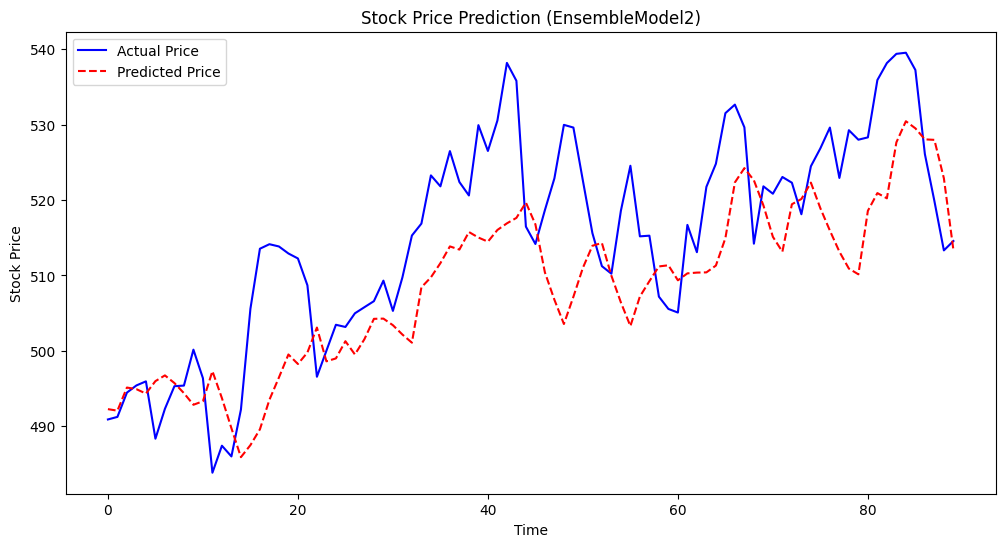


🎯 EnsembleModel2 Model Training & Prediction Complete! 🚀


In [12]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, SimpleRNN, LSTM, Dense, Dropout, Concatenate, Multiply, BatchNormalization, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# === Define Model Save Path ===
ensemble_folder = "EnsembleModel2"
os.makedirs(ensemble_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_val = np.load("X_val.npy")
y_val = np.load("y_val.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the correct scaler for stock prices
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# === Step 2: Hyperparameter Tuning ===
def build_ensemble_model(hp):
    """Builds an improved Ensemble Model combining CNN, RNN, and LSTM with Attention and Adaptive Weighted Fusion."""
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # === CNN Branch ===
    cnn = Conv1D(filters=hp.Choice('cnn_filters', [64, 128, 256]),
                 kernel_size=hp.Choice('cnn_kernel_size', [3, 5, 7]),
                 activation='relu')(inputs)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)
    cnn_weight = Dense(1, activation='sigmoid')(cnn)  # Adaptive weighting

    # === RNN Branch ===
    rnn = SimpleRNN(units=hp.Choice('rnn_units', [75, 100, 125]), return_sequences=True)(inputs)
    rnn = SimpleRNN(units=hp.Choice('rnn_units_2', [75, 100, 125]), return_sequences=True)(rnn)
    rnn = Attention()([rnn, rnn])
    rnn = Flatten()(rnn)
    rnn_weight = Dense(1, activation='sigmoid')(rnn)  # Adaptive weighting

    # === LSTM Branch ===
    lstm = LSTM(units=hp.Choice('lstm_units', [50, 75, 100]), return_sequences=True)(inputs)
    lstm = LSTM(units=hp.Choice('lstm_units_2', [50, 75, 100]), return_sequences=True)(lstm)
    lstm = Attention()([lstm, lstm])
    lstm = Flatten()(lstm)
    lstm_weight = Dense(1, activation='sigmoid')(lstm)  # Adaptive weighting

    # === Adaptive Weighted Fusion ===
    cnn_scaled = Multiply()([cnn, cnn_weight])
    rnn_scaled = Multiply()([rnn, rnn_weight])
    lstm_scaled = Multiply()([lstm, lstm_weight])

    merged = Concatenate()([cnn_scaled, rnn_scaled, lstm_scaled])
    merged = Dense(units=hp.Choice('dense_units', [50, 100, 150]), activation="relu")(merged)
    merged = Dropout(hp.Choice('dropout_rate', [0.1, 0.2, 0.3]))(merged)

    # Output Layer
    output = Dense(1)(merged)

    # Compile Model
    model = Model(inputs, output)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss="mse",
        metrics=["mae"]
    )
    return model

# ✅ Run Hyperparameter Tuning (Now Uses Validation Data)
tuner = kt.RandomSearch(
    build_ensemble_model,
    objective="val_loss",
    max_trials=15,
    executions_per_trial=3,
    directory=os.path.join(ensemble_folder, "tuning"),
    project_name="stock_prediction_ensemble"
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

# ✅ Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# ✅ Save Best Hyperparameters
best_hps_dict = {param: best_hps.get(param) for param in best_hps.values.keys()}
with open(os.path.join(ensemble_folder, "best_hyperparameters.json"), "w") as f:
    json.dump(best_hps_dict, f)
print(f"✅ Best hyperparameters saved in {ensemble_folder}!")

# ✅ Set Batch Size
BATCH_SIZE = 32  # Increased batch size for improved training

# === Step 3: Train the Best Model with Learning Rate Decay ===
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),  # ✅ Uses validation data
    callbacks=[reduce_lr],
    verbose=1
)

# ✅ Save the Best Model
best_model.save(os.path.join(ensemble_folder, "best_ensemble_model.keras"))
print(f"✅ Best Ensemble Model saved in {ensemble_folder}!")

# === Step 4: Evaluate the Model on Test Data ===
loss, mae = best_model.evaluate(X_test, y_test)
print(f"✅ Best Model Test Loss: {loss}")
print(f"✅ Best Model Test MAE: {mae}")

# === Step 5: Make Predictions ===
predictions = best_model.predict(X_test)

# === Step 6: Reverse Scale Predictions and Actual Values ===
def inverse_transform_single_feature(scaler, data):
    """Properly inverse transforms a single feature using the original scaler."""
    data = np.array(data).reshape(-1, 1)
    return scaler.inverse_transform(data)

# ✅ Rescale Predictions and Actual Prices
predictions_rescaled = inverse_transform_single_feature(scaler_y, predictions)
y_test_rescaled = inverse_transform_single_feature(scaler_y, y_test)

# === Step 7: Plot Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.title(f"Stock Price Prediction ({ensemble_folder})")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print(f"\n🎯 {ensemble_folder} Model Training & Prediction Complete! 🚀")
